In [1]:
import datetime
import numpy as np
import pandas as pd
!pip install pymarket
import pymarket as pm
import matplotlib.pyplot as plt
from pprint import pprint
import glob
%matplotlib inline
pd.set_option('display.notebook_repr_html', False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pymarket: filename=pymarket-0.7.6-py2.py3-none-any.whl size=36508 sha256=745866df1e4038f41ade2542a4b5241322005b2215296f17f2070d70c5b80098
  Stored in directory: /root/.cache/pip/wheels/54/3a/c8/c3f4012c20162cac789df52b333cbfc9dbde6ef7dea6a1ef89
Successfully built pymarket


In [2]:
def uniform_price_mechanism(bids: pd.DataFrame) -> (pm.TransactionManager, dict):
    
    trans = pm.TransactionManager()
    
    buy, _ = pm.bids.demand_curve_from_bids(bids) # Creates demand curve from bids
    sell, _ = pm.bids.supply_curve_from_bids(bids) # Creates supply curve from bids

    # q_ is the quantity at which supply and demand meet
    # price is the price at which that happens
    # b_ is the index of the buyer in that position
    # s_ is the index of the seller in that position
    q_, b_, s_, price = pm.bids.intersect_stepwise(buy, sell)
    
    if b_ is None or s_ is None:
        # No market clearing can be made, return empty TransactionManager and clearing price of 0
        return trans, {'clearing quantity': 0, 'clearing price': 0} #deze moet van retail dan worden gehaald
    
    buying_bids  = bids.loc[bids['buying']].sort_values('price', ascending=False)
    selling_bids = bids.loc[~bids['buying']].sort_values('price', ascending=True)
    
    ## Filter only the trading bids.
    buying_bids = buying_bids.iloc[: b_ + 1, :]
    selling_bids = selling_bids.iloc[: s_ + 1, :]
    
    # Find the long side of the market
    buying_quantity = buying_bids.quantity.sum()
    selling_quantity = selling_bids.quantity.sum()
    
    
    if buying_quantity > selling_quantity:
        long_side = buying_bids
        short_side = selling_bids
    else:
        long_side = selling_bids
        short_side = buying_bids
        
    traded_quantity = short_side.quantity.sum()
    
    ## All the short side will trade at `price`
    ## The -1 is there because there is no clear 1 to 1 trade.
    for i, x in short_side.iterrows():
        t = (i, x.quantity, price, -1, False)
        trans.add_transaction(*t)

    ## The long side has to trade only up to the short side
    quantity_added = 0
    for i, x in long_side.iterrows():
        
        if x.quantity + quantity_added <= traded_quantity:
            x_quantity = x.quantity
        else:
            x_quantity = traded_quantity - quantity_added
        t = (i, x_quantity, price, -1, False)
        trans.add_transaction(*t)
        quantity_added += x.quantity
        
    extra = {
        'clearing quantity': q_,
        'clearing price': price
    }
    
    return trans, extra

# Observe that we add as the second argument of init the algorithm just coded
class UniformPrice(pm.Mechanism):
    """
    Interface for our new uniform price mechanism.
    
    Parameters
    -----------
    bids
        Collection of bids to run the mechanism
        with.
    """

    def __init__(self, bids, *args, **kwargs):
        """TODO: to be defined1. """
        pm.Mechanism.__init__(self, uniform_price_mechanism, bids, *args, **kwargs)

pm.market.MECHANISM['uniform'] = UniformPrice


In [3]:
from pymarket.bids import BidManager
from pymarket.mechanisms import *
from pymarket.transactions import TransactionManager
from pymarket.statistics import *
from pymarket.plot import plot_demand_curves, plot_trades_as_graph, plot_both_side_muda, plot_huang_auction
from collections import OrderedDict

MECHANISM = {
    'huang': HuangAuction,
    'p2p': P2PTrading,
    'uniform' : UniformPrice
}

STATS = {

    'percentage_traded': percentage_traded,
    'percentage_welfare': percentage_welfare,
    'profits': calculate_profits,
}


class Market():

    """General interface for calling the different
    market mechanisms

    Parameters
    ----------
    bm: BidManager
        All bids are stored in the bid manager
    transactions: TransactionManager
        The set of all tranasactions in the Market.
        This argument get updated after the market ran.
    extra: dict
        Extra information provided by the mechanisms.
        Gets updated after an execution of the run.

    Returns
    -------


    Examples
    ---------

    If everyone is buying, the transaction
    dataframe is returned empty as well as the extra
    dictionary.

    >>> mar = pm.Market()
    >>> mar.accept_bid(1, 2, 0, True)
    0
    >>> mar.accept_bid(2, 3, 1, True)
    1
    >>> trans, extra = mar.run('huang')
    >>> extra
    OrderedDict()
    >>> trans.get_df()
    Empty DataFrame
    Columns: [bid, quantity, price, source, active]
    Index: []

    If everyone is buying, the transaction
    dataframe is returned empty as well as the extra
    dictionary.

    >>> mar = pm.Market()
    >>> mar.accept_bid(1, 2, 0, False)
    0
    >>> mar.accept_bid(2, 3, 1, False)
    1
    >>> trans, extra = mar.run('huang')
    >>> extra
    OrderedDict()
    >>> trans.get_df()
    Empty DataFrame
    Columns: [bid, quantity, price, source, active]
    Index: []

    A very simple auction where nobody trades

    >>> mar = pm.Market()
    >>> mar.accept_bid(1, 3, 0, True)
    0
    >>> mar.accept_bid(1, 2, 1, False)
    1
    >>> trans, extra = mar.run('huang')
    >>> extra
    OrderedDict([('price_sell', 2.0), ('price_buy', 3.0), ('quantity_traded', 0)])
    >>> trans.get_df()
    Empty DataFrame
    Columns: [bid, quantity, price, source, active]
    Index: []

    """

    def __init__(self):
        """TODO: to be defined1."""
        self.bm = BidManager()
        self.transactions = TransactionManager()
        self.extra = OrderedDict()


    def accept_bid(self, *args):
        """Adds a bid to the bid manager

        Parameters
        ----------           
        *args :
            List of parameters requried to create a bid.
            See `BidManager` documentation.

        Returns
        -------
        bid_id: int
            The id of the new created bid in the BidManger
        
        """
        bid_id = self.bm.add_bid(*args)
        return bid_id
    
    def clear_bids(self):
        """Clears the bids list"""
        self.bids = []
        self.n_bids = 0

    def run(self, algo, *args, **kwargs):
        """Runs a given mechanism with the current
        bids

        Parameters
        ----------
        algo : str
            One of:
                * 'p2p'
                * 'huang'
                * 'muda'
            
        *args :
            Extra arguments to pass to the algorithm.

        **kwargs :
            Extra keyworded arguments to pass to the algorithm


        Returns
        -------
        transactions: TransactionManager
            The transaction manager holding all the transactions
            returned by the mechanism.
        extra: dict
            Dictionary with extra information returned by the
            executed method.

        
        """
        df = self.bm.get_df()
        mec = MECHANISM[algo](df, *args, **kwargs)
        transactions, extra = mec.run()
        self.transactions = transactions
        self.extra = extra
        return transactions, extra

    def statistics(self, reservation_prices=None, exclude=[]):
        """Computes the standard statistics of the market

        Parameters
        ----------
        reservation_prices (dict, optional) :
            the reservation prices of the users. If there is none,
            the bid will be assumed truthfull
        reservation_prices :
             (Default value = None)
        exclude :
            List of mechanisms to ignore will comuting statistics

        Returns
        -------
        stats : dict
            Dictionary with the differnt statistics. Currently:
                * percentage_welfare
                * percentage_traded
                * profits

        
        """
        stats = OrderedDict()
        extras = OrderedDict()
        if 'fees' in self.extra:
            extras['fees'] = self.extra['fees']
        extras['reservation_prices'] = reservation_prices
        for stat in STATS:
            if stat not in exclude:
                stats[stat] = STATS[stat](
                    self.bm.get_df(),
                    self.transactions.get_df(),
                    **extras
                )
        self.stats = stats
        return stats

    def plot(self):
        """Plots both demand curves"""
        df = self.bm.get_df()
        plot_demand_curves(df)

    def plot_method(self, method, ax=None):
        """
        Plots a figure specific for a given method,
        reflecting the main characteristics of its solution.
        It requires that the algorithm has run before. 


        Parameters
        ----------
        method : str
            One of `p2p`, `muda`, `huang`
        ax :
             (Default value = None)

        Returns
        -------

        
        """

        trans = self.transactions
        bids = self.bm
        e = self.extra
        if method == 'p2p':
            ax = plot_trades_as_graph(bids, trans, ax)
        elif method == 'muda':
            try:
                left_players = e['left']
                right_players = e['right']
                left_price = e['price_left']
                right_price = e['price_right']
                ax = plot_both_side_muda(
                    bids,
                    left_players,
                    right_players,
                    left_price,
                    right_price)
            except KeyError as e:
                print('Some of the parameters required were not found',
                'Make sure that the algorithm executed correctly.')
        elif method == 'huang':
            try:
                price_sell = e['price_sell']
                price_buy = e['price_buy']
                quantity_traded = e['quantity_traded']
                ax = plot_huang_auction(
                    bids,
                    price_sell,
                    price_buy,
                    quantity_traded,
                    ax
                )
            except KeyError as e:
                print('Some of the parameters required were not found',
                    'Make sure that the algorithm executed correctly.')
        return ax

In [4]:
mar = pm.Market()
r = np.random.RandomState(1234)
df = pd.read_csv('/kaggle/input/biozon-7-dagen/positions_market_ex_ante.csv') 
df['ts_delivery'] = pd.to_datetime(df['ts_delivery'], unit='s')
df.set_index('ts_delivery', inplace=True)
df['price_energy'] = df['price_energy']/1000000 #naar kWh
df = df[df['id_user'] != 777777] #exclude retailer
df


                     Unnamed: 0  id_user  qty_energy  price_energy  \
ts_delivery                                                          
2021-02-23 23:15:00           0        9         124        0.1848   
2021-02-23 23:30:00           1        9         106        0.1931   
2021-02-24 00:00:00           2        9          62        0.1698   
2021-02-24 00:45:00           3       13         102        0.1584   
2021-02-24 00:30:00           4        9          76        0.1627   
...                         ...      ...         ...           ...   
2021-03-02 15:15:00       45076        7        1200        0.4240   
2021-03-03 13:30:00       45077        7          40        0.4343   
2021-03-03 13:00:00       45078        3         120        0.2465   
2021-03-03 13:15:00       45079        3        1941        0.1352   
2021-03-03 04:45:00       45080       22        1380        0.2238   

                    quality_energy  premium_preference_quality type_position  \
ts_delive

In [5]:
df.sort_index()
start_date = "2021-02-23 23:15:00"
end_date = "2021-03-03 13:15:00"
mask = (df.index >= start_date) & (df.index < end_date)
df = df.loc[mask]
df

                     Unnamed: 0  id_user  qty_energy  price_energy  \
ts_delivery                                                          
2021-02-23 23:15:00           0        9         124        0.1848   
2021-02-23 23:30:00           1        9         106        0.1931   
2021-02-24 00:00:00           2        9          62        0.1698   
2021-02-24 00:45:00           3       13         102        0.1584   
2021-02-24 00:30:00           4        9          76        0.1627   
...                         ...      ...         ...           ...   
2021-03-02 20:00:00       45074       22          68        0.0956   
2021-03-02 15:00:00       45075        7        1040        0.1291   
2021-03-02 15:15:00       45076        7        1200        0.4240   
2021-03-03 13:00:00       45078        3         120        0.2465   
2021-03-03 04:45:00       45080       22        1380        0.2238   

                    quality_energy  premium_preference_quality type_position  \
ts_delive

# Double Auction

/tmp/ipykernel_20/2666709085.py:104: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


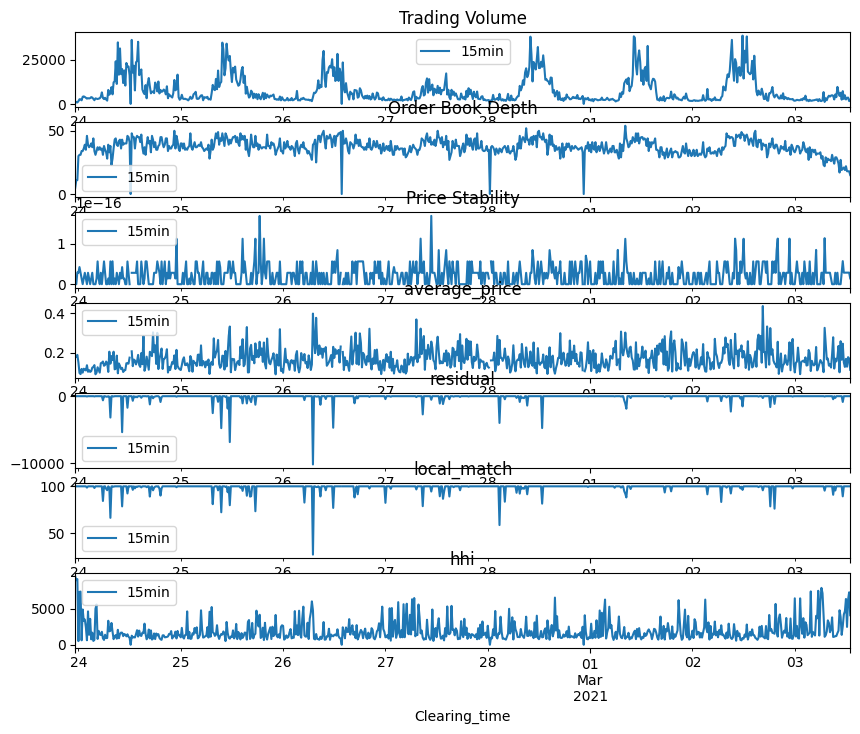

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

freqs = ['15min']#, '30min', '15min']
performance_data = []

for freq in freqs:
    groups = df.groupby(pd.Grouper(freq=freq))

    bids_all = []
    merged_dfs = []

    liquidity_data = []

    for name, group in groups:
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()  # Create a copy of the group
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, row['quality_energy'])
            bids_all.append(bid)
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('uniform')
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))
        merged_dfs.append(merged_df)

        # Calculate liquidity metrics
        unique_offers = merged_df.loc[~merged_df['buying'], ['user', 'quantity_bid','quantity_trans']].drop_duplicates('user')
        unique_bids = merged_df.loc[merged_df['buying'], ['user', 'quantity_bid','quantity_trans']].drop_duplicates('user')
        
        bid_quantity_sum = unique_bids['quantity_bid'].sum()
        offer_quantity_sum = unique_offers['quantity_bid'].sum()
        cleared_volume = unique_bids['quantity_trans'].sum()    
        residual = cleared_volume - bid_quantity_sum
        
        local_match = cleared_volume / bid_quantity_sum * 100 if bid_quantity_sum else float('nan')
        retailer_match = 100 - local_match if bid_quantity_sum else float('nan')
    
        trading_volume = unique_bids['quantity_trans'].sum()
        order_book_depth = len(merged_df)
        price_stability = merged_df['price_trans'].std()
        average_price = merged_df['price_trans'].mean()
        
        # Step 1: Calculate market shares
        market_shares = merged_df.groupby('user')['quantity_bid'].sum() / merged_df['quantity_bid'].sum()
        # Step 2: Square the market shares
        squared_market_shares = market_shares ** 2
        # Step 3: Calculate the sum of squared market shares
        HHI = squared_market_shares.sum()
        # Step 4: Scale the HHI by multiplying by 10,000
        hhi = HHI * 10000
        
        liquidity_data.append([name, trading_volume, order_book_depth, price_stability, average_price, residual, local_match, hhi])

    merged_df = pd.concat(merged_dfs, ignore_index=False)
    merged_df.set_index('time', inplace=True)

    merged_df = merged_df[merged_df['quantity_trans'] != 0]

    df_bids_all = pd.DataFrame(bids_all, columns=['qty_energy', 'price_energy', 'id_user', 'is_bid', 'clearing_time', 'quality_energy'])
    df_bids_all.set_index('clearing_time', inplace=True)

    # Group the data by clearing time
    groups = merged_df.groupby(merged_df.index)

    liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading_volume', 'Order_book_depth', 'Price_stability','average_price', 'residual','local_match', 'hhi'])
    liquidity_data_df.set_index('Clearing_time', inplace=True)
    
    performance_data.append(liquidity_data_df)

# Plotting the performance comparison
fig, axs = plt.subplots(7, 1, figsize=(10, 8))

for i, freq in enumerate(freqs):
    performance_data[i]['Trading_volume'].plot(ax=axs[0], label=freq)
    performance_data[i]['Order_book_depth'].plot(ax=axs[1], label=freq)
    performance_data[i]['Price_stability'].plot(ax=axs[2], label=freq)
    performance_data[i]['average_price'].plot(ax=axs[3], label=freq)
    performance_data[i]['residual'].plot(ax=axs[4], label=freq)
    performance_data[i]['local_match'].plot(ax=axs[5], label=freq)
    performance_data[i]['hhi'].plot(ax=axs[6], label=freq)  
    
axs[0].set_title('Trading Volume')
axs[1].set_title('Order Book Depth')
axs[2].set_title('Price Stability')
axs[3].set_title('average_price')
axs[4].set_title('residual')
axs[5].set_title('local_match')
axs[6].set_title('hhi')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()
axs[5].legend()
axs[6].legend()

plt.tight_layout()
plt.show()


for i, freq in enumerate(freqs):
    performance_data[i].to_csv(f'performance_data_auc_{freq}.csv')

/tmp/ipykernel_20/51636916.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  second_df = merged_df.groupby(merged_df.index).mean()  # for 15 min


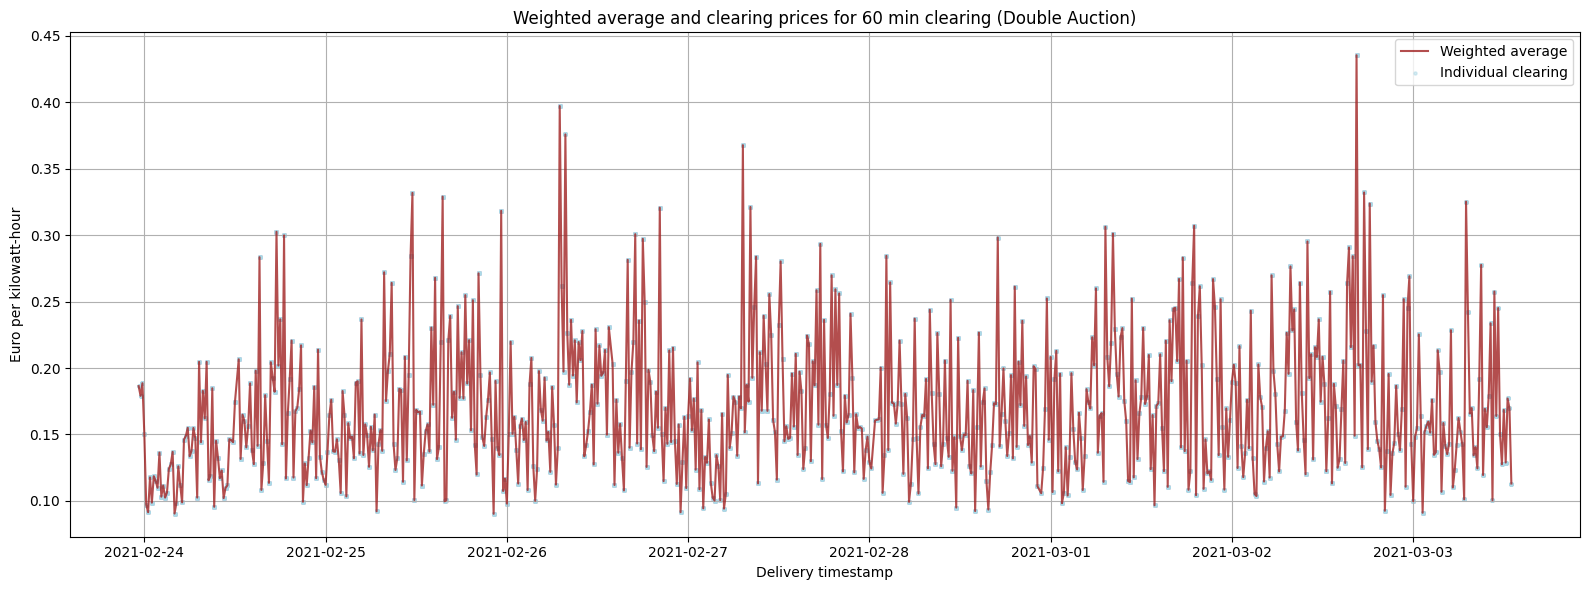

0.05265778905463162
0.17014792817679555


In [7]:
import matplotlib.pyplot as plt

second_df = merged_df.groupby(merged_df.index).mean()  # for 15 min

# Increase figure size
plt.figure(figsize=(16, 6))

# Plot weighted average
xvalues = second_df.index
yvalues = second_df['price_trans'].tolist()
plt.plot(xvalues, yvalues, color="#a02222", alpha=0.8, label="Weighted average")

# Plot second line
xvalues = merged_df.index
yvalues = merged_df['price_trans'].tolist()
plt.scatter(xvalues, yvalues, color="LightBlue", alpha=0.5, s=5, label="Individual clearing")

# Add labels, title, and legend
plt.xlabel("Delivery timestamp")
plt.ylabel("Euro per kilowatt-hour")
plt.title("Weighted average and clearing prices for 60 min clearing (Double Auction)")
plt.legend()

# Add grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()

# Save the plot as a vector plot in EPS format
plt.savefig("auct_60min.eps", format="eps")

# Show the plot
plt.show()

volatility_auct = second_df['price_trans'].std()
print(volatility_auct)
wavg_auct = second_df['price_trans'].mean()
print(wavg_auct)

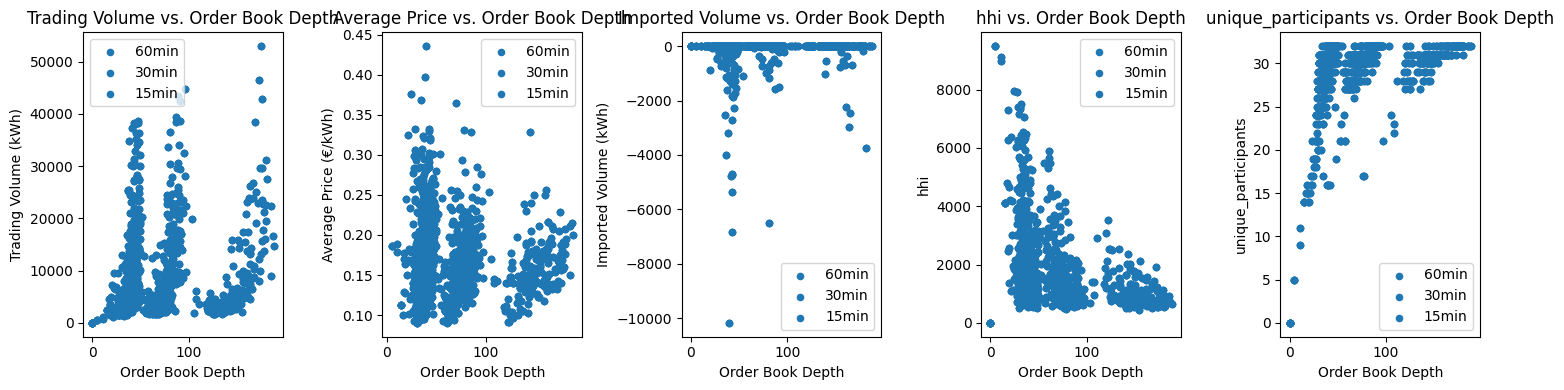

In [8]:
freqs = ['60min', '30min', '15min']

performance_data = []
liquidity_data = []

for freq in freqs:
    for name, group in df.groupby(pd.Grouper(freq=freq)):
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, row['quality_energy'])
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('uniform')
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))

        unique_offers = merged_df.loc[~merged_df['buying'], ['user', 'quantity_bid', 'quantity_trans']].drop_duplicates('user')
        unique_bids = merged_df.loc[merged_df['buying'], ['user', 'quantity_bid', 'quantity_trans']].drop_duplicates('user')

        trading_volume = unique_bids['quantity_trans'].sum()
        order_book_depth = len(merged_df)
        average_price = merged_df['price_trans'].mean()
        residual = trading_volume - unique_bids['quantity_bid'].sum()
        unique_participants = len(merged_df['user'].unique())
        
        # Step 1: Calculate market shares
        market_shares = merged_df.groupby('user')['quantity_bid'].sum() / merged_df['quantity_bid'].sum()
        # Step 2: Square the market shares
        squared_market_shares = market_shares ** 2
        # Step 3: Calculate the sum of squared market shares
        HHI = squared_market_shares.sum()
        # Step 4: Scale the HHI by multiplying by 10,000
        hhi = HHI * 10000
        
        liquidity_data.append([clearing_time, trading_volume, order_book_depth, average_price, residual, hhi, unique_participants])

liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading Volume (kWh)', 'Order Book Depth', 'Average Price (€/kWh)', 'Imported Volume (kWh)', 'hhi','unique_participants'])
performance_data.append(liquidity_data_df)

fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for freq in freqs:
    performance_data[0].plot.scatter(x='Order Book Depth', y='Trading Volume (kWh)', ax=axs[0], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='Average Price (€/kWh)', ax=axs[1], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='Imported Volume (kWh)', ax=axs[2], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='hhi', ax=axs[3], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='unique_participants', ax=axs[4], label=freq)
        
axs[0].set_title('Trading Volume vs. Order Book Depth')
axs[1].set_title('Average Price vs. Order Book Depth')
axs[2].set_title('Imported Volume vs. Order Book Depth')
axs[3].set_title('hhi vs. Order Book Depth')
axs[4].set_title('unique_participants vs. Order Book Depth')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.tight_layout()
plt.show()



# Negotiation-based mechanism (P2P)

/tmp/ipykernel_20/767488851.py:104: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


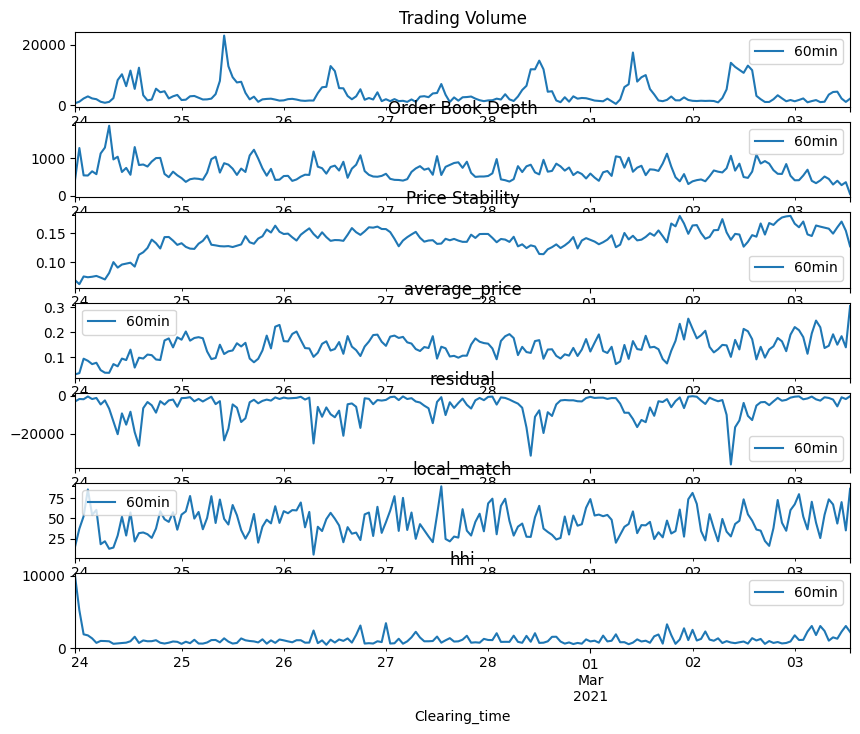

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

freqs = ['60min']#, '30min', '15min']
performance_data = []

for freq in freqs:
    groups = df.groupby(pd.Grouper(freq=freq))

    bids_all = []
    merged_dfs = []

    liquidity_data = []

    for name, group in groups:
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()  # Create a copy of the group
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, row['quality_energy'])
            bids_all.append(bid)
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('p2p', r=r)
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))
        merged_dfs.append(merged_df)

        # Calculate liquidity metrics
        unique_offers = merged_df.loc[~merged_df['buying'], ['user', 'quantity_bid','quantity_trans']].drop_duplicates('user')
        unique_bids = merged_df.loc[merged_df['buying'], ['user', 'quantity_bid','quantity_trans']].drop_duplicates('user')
        
        bid_quantity_sum = unique_bids['quantity_bid'].sum()
        offer_quantity_sum = unique_offers['quantity_bid'].sum()
        cleared_volume = unique_bids['quantity_trans'].sum()    
        residual = cleared_volume - bid_quantity_sum
        
        local_match = cleared_volume / bid_quantity_sum * 100 if bid_quantity_sum else float('nan')
        retailer_match = 100 - local_match if bid_quantity_sum else float('nan')
    
        trading_volume = unique_bids['quantity_trans'].sum()
        order_book_depth = len(merged_df)
        price_stability = merged_df['price_trans'].std()
        average_price = merged_df['price_trans'].mean()
        
        # Step 1: Calculate market shares
        market_shares = merged_df.groupby('user')['quantity_bid'].sum() / merged_df['quantity_bid'].sum()
        # Step 2: Square the market shares
        squared_market_shares = market_shares ** 2
        # Step 3: Calculate the sum of squared market shares
        HHI = squared_market_shares.sum()
        # Step 4: Scale the HHI by multiplying by 10,000
        hhi = HHI * 10000
        
        liquidity_data.append([name, trading_volume, order_book_depth, price_stability, average_price, residual, local_match, hhi])

    merged_df = pd.concat(merged_dfs, ignore_index=False)
    merged_df.set_index('time', inplace=True)

    merged_df = merged_df[merged_df['quantity_trans'] != 0]

    df_bids_all = pd.DataFrame(bids_all, columns=['qty_energy', 'price_energy', 'id_user', 'is_bid', 'clearing_time', 'quality_energy'])
    df_bids_all.set_index('clearing_time', inplace=True)

    # Group the data by clearing time
    groups = merged_df.groupby(merged_df.index)

    liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading_volume', 'Order_book_depth', 'Price_stability','average_price', 'residual','local_match', 'hhi'])
    liquidity_data_df.set_index('Clearing_time', inplace=True)
    
    performance_data.append(liquidity_data_df)

# Plotting the performance comparison
fig, axs = plt.subplots(7, 1, figsize=(10, 8))

for i, freq in enumerate(freqs):
    performance_data[i]['Trading_volume'].plot(ax=axs[0], label=freq)
    performance_data[i]['Order_book_depth'].plot(ax=axs[1], label=freq)
    performance_data[i]['Price_stability'].plot(ax=axs[2], label=freq)
    performance_data[i]['average_price'].plot(ax=axs[3], label=freq)
    performance_data[i]['residual'].plot(ax=axs[4], label=freq)
    performance_data[i]['local_match'].plot(ax=axs[5], label=freq)
    performance_data[i]['hhi'].plot(ax=axs[6], label=freq)  
    
axs[0].set_title('Trading Volume')
axs[1].set_title('Order Book Depth')
axs[2].set_title('Price Stability')
axs[3].set_title('average_price')
axs[4].set_title('residual')
axs[5].set_title('local_match')
axs[6].set_title('hhi')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()
axs[5].legend()
axs[6].legend()

plt.tight_layout()
plt.show()


for i, freq in enumerate(freqs):
    performance_data[i].to_csv(f'performance_data_p2p_{freq}.csv')

/tmp/ipykernel_20/826799620.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  second_df = merged_df.groupby(merged_df.index).mean()  # for 15 min


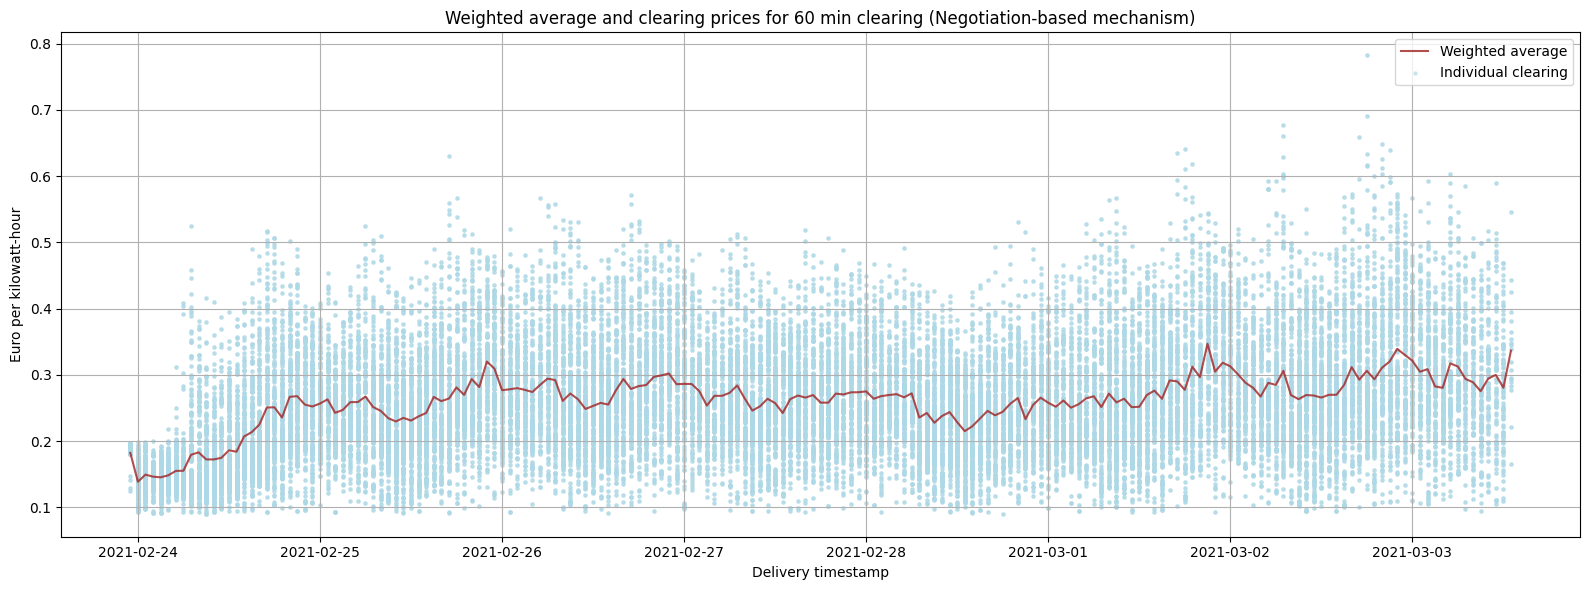

0.03833915554426819
0.2622710079796577


In [10]:
import matplotlib.pyplot as plt

second_df = merged_df.groupby(merged_df.index).mean()  # for 15 min

# Increase figure size
plt.figure(figsize=(16, 6))

# Plot weighted average
xvalues = second_df.index
yvalues = second_df['price_trans'].tolist()
plt.plot(xvalues, yvalues, color="#a02222", alpha=0.8, label="Weighted average")

# Plot second line
xvalues = merged_df.index
yvalues = merged_df['price_trans'].tolist()
plt.scatter(xvalues, yvalues, color="LightBlue", alpha=0.5, s=5, label="Individual clearing")

# Add labels, title, and legend
plt.xlabel("Delivery timestamp")
plt.ylabel("Euro per kilowatt-hour")
plt.title("Weighted average and clearing prices for 60 min clearing (Negotiation-based mechanism)")
plt.legend()

# Add grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()

# Save the plot as a vector plot in EPS format
plt.savefig("p2p_60min.eps", format="eps")

# Show the plot
plt.show()

volatility_p2p = second_df['price_trans'].std()
print(volatility_p2p)
wavg_p2p = second_df['price_trans'].mean()
print(wavg_p2p)

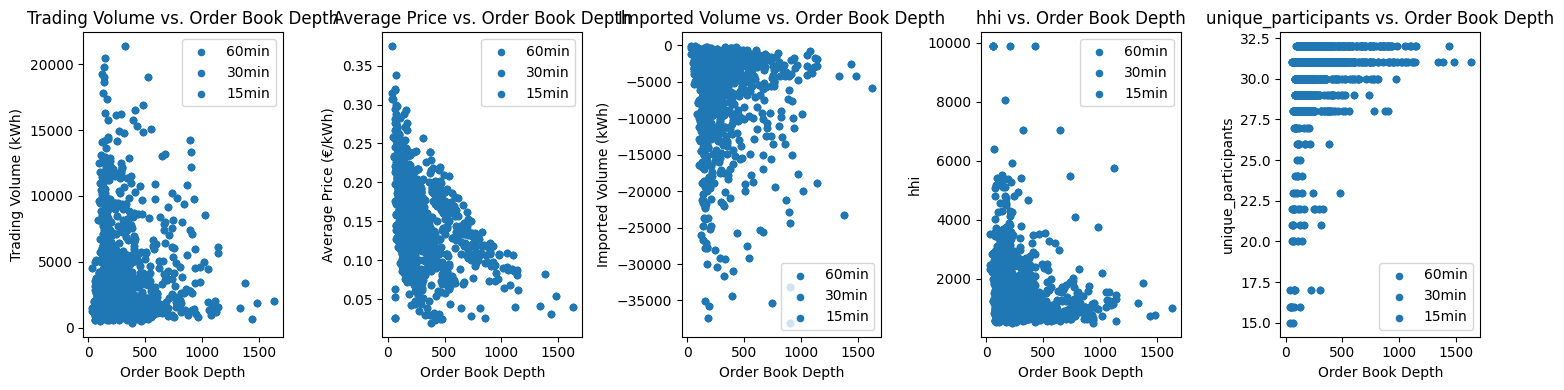

In [11]:
freqs = ['60min', '30min', '15min']

performance_data = []
liquidity_data = []

for freq in freqs:
    for name, group in df.groupby(pd.Grouper(freq=freq)):
        mar = Market()
        clearing_time = pd.to_datetime(name)
        group = group.copy()
        group['clearing_time'] = clearing_time

        for _, row in group.iterrows():
            bid = (row['qty_energy'], row['price_energy'], row['id_user'], row['type_position'] == 'bid', clearing_time, row['quality_energy'])
            mar.accept_bid(*bid)

        bids_df = mar.bm.get_df()
        transactions, extras = mar.run('p2p',r=r)
        merged_df = pd.merge(bids_df, transactions.get_df(), left_index=True, right_on='bid', suffixes=('_bid', '_trans'))

        unique_offers = merged_df.loc[~merged_df['buying'], ['user', 'quantity_bid', 'quantity_trans']].drop_duplicates('user')
        unique_bids = merged_df.loc[merged_df['buying'], ['user', 'quantity_bid', 'quantity_trans']].drop_duplicates('user')

        trading_volume = unique_bids['quantity_trans'].sum()
        order_book_depth = len(merged_df)
        average_price = merged_df['price_trans'].mean()
        residual = trading_volume - unique_bids['quantity_bid'].sum()
        unique_participants = len(merged_df['user'].unique())
        
        # Step 1: Calculate market shares
        market_shares = merged_df.groupby('user')['quantity_bid'].sum() / merged_df['quantity_bid'].sum()
        # Step 2: Square the market shares
        squared_market_shares = market_shares ** 2
        # Step 3: Calculate the sum of squared market shares
        HHI = squared_market_shares.sum()
        # Step 4: Scale the HHI by multiplying by 10,000
        hhi = HHI * 10000
        
        liquidity_data.append([clearing_time, trading_volume, order_book_depth, average_price, residual, hhi, unique_participants])

liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading Volume (kWh)', 'Order Book Depth', 'Average Price (€/kWh)', 'Imported Volume (kWh)', 'hhi','unique_participants'])
performance_data.append(liquidity_data_df)

fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for freq in freqs:
    performance_data[0].plot.scatter(x='Order Book Depth', y='Trading Volume (kWh)', ax=axs[0], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='Average Price (€/kWh)', ax=axs[1], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='Imported Volume (kWh)', ax=axs[2], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='hhi', ax=axs[3], label=freq)
    performance_data[0].plot.scatter(x='Order Book Depth', y='unique_participants', ax=axs[4], label=freq)
        
axs[0].set_title('Trading Volume vs. Order Book Depth')
axs[1].set_title('Average Price vs. Order Book Depth')
axs[2].set_title('Imported Volume vs. Order Book Depth')
axs[3].set_title('hhi vs. Order Book Depth')
axs[4].set_title('unique_participants vs. Order Book Depth')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.tight_layout()
plt.show()



# System-determined mechanism

In [12]:
df_bids_all['buying']=df_bids_all['is_bid']
df_bids_all['quantity_bid']=df_bids_all['qty_energy']
df_bids_all['user']=df_bids_all['id_user']

In [13]:
prosumer_cost_price = 0.09
large_scale_pv_cost_price = 0.078
fixed_generator_cost_price = 0.055

In [14]:
freqs = ['15min']#, '30min', '15min']
performance_data = []

for freq in freqs:
    groups = df_bids_all.groupby(pd.Grouper(freq=freq))
    offers = []
    bids = []

    for name, group in groups:
        clearing_time = datetime.datetime.fromtimestamp(int(datetime.datetime.timestamp(name)))
        clearing_period = group.loc[clearing_time:clearing_time]

        unique_offers = clearing_period.loc[~clearing_period['buying'], ['user', 'quantity_bid']].drop_duplicates('user')
        unique_bids = clearing_period.loc[clearing_period['buying'], ['user', 'quantity_bid']].drop_duplicates('user')

        offers.append(unique_offers[['user', 'quantity_bid']])
        bids.append(unique_bids[['user', 'quantity_bid']])

        all_unique_offers = pd.concat(offers)
        all_unique_bids = pd.concat(bids)

        sellers = all_unique_offers.copy()
        sellers['type'] = 'prosumer'
        sellers.loc[sellers['user'] == 31, 'type'] = 'large_scale_pv'
        sellers.loc[sellers['user'] == 32, 'type'] = 'fixed_generator'
        sellers['cost_price'] = prosumer_cost_price
        sellers.loc[sellers['type'] == 'large_scale_pv', 'cost_price'] = large_scale_pv_cost_price
        sellers.loc[sellers['type'] == 'fixed_generator', 'cost_price'] = fixed_generator_cost_price
        sellers['Demand'] = all_unique_bids.groupby(all_unique_bids.index)['quantity_bid'].sum()
        sellers = sellers.rename_axis('time')

grouped_df = sellers.groupby('time')
dfs = []
for group_name, group_data in grouped_df:
    sorted_data = group_data.sort_values('cost_price', ascending=True)
    sorted_data = sorted_data.reset_index(drop=False)
    sorted_data.groupby('user')
    sorted_data['cumulative_cleared_volume'] = sorted_data['quantity_bid'].cumsum()
    demand = sorted_data['Demand'].unique()[0]
    sorted_data['cleared_volume'] = sorted_data['cumulative_cleared_volume'].clip(upper=demand)
    sorted_data['cleared_volume'] = sorted_data['cleared_volume'].diff().fillna(sorted_data['cleared_volume'].iloc[0])

    dfs.append(sorted_data)
    
sorted_data = pd.concat(dfs, ignore_index=True)
sorted_data = sorted_data.set_index('time')
sorted_data


                     user  quantity_bid             type  cost_price  Demand  \
time                                                                           
2021-02-23 23:00:00    32         21250  fixed_generator       0.055    3658   
2021-02-23 23:00:00    23            50         prosumer       0.090    3658   
2021-02-23 23:00:00    19           102         prosumer       0.090    3658   
2021-02-24 00:00:00    32         13840  fixed_generator       0.055    2855   
2021-02-24 00:00:00    18            26         prosumer       0.090    2855   
...                   ...           ...              ...         ...     ...   
2021-03-03 13:00:00    26            48         prosumer       0.090    2388   
2021-03-03 13:00:00    18           624         prosumer       0.090    2388   
2021-03-03 13:00:00    22           140         prosumer       0.090    2388   
2021-03-03 13:00:00     2            38         prosumer       0.090    2388   
2021-03-03 13:00:00     3           120 

In [15]:
unique_participants = len(sorted_data['user'].unique())
unique_participants

32

In [16]:
#freqs = ['15min']#, '30min', '15min']
performance_data = []

for freq in freqs:
    groups = sorted_data.groupby('time')
    for name, group in groups:
        liquidity_data = []
        trading_volume = group['cleared_volume'].sum()
        demand = group['Demand'].unique().sum()#.unique()
        residual = trading_volume - demand
        local_match = trading_volume / demand * 100 if demand else float(0)
        retailer_match = 100 - local_match if demand else float(0)

        order_book_depth = len(group)
        price_stability = group['cost_price'].std()
        average_price = group['cost_price'].mean()
        unique_participants = len(group['user'].unique())

        # Step 1: Calculate market shares
        market_shares = group.groupby('user')['quantity_bid'].sum() / group['quantity_bid'].sum()
        # Step 2: Square the market shares
        squared_market_shares = market_shares ** 2
        # Step 3: Calculate the sum of squared market shares
        HHI = squared_market_shares.sum()
        # Step 4: Scale the HHI by multiplying by 10,000
        hhi = HHI * 10000
        
        liquidity_data.append([name, trading_volume, order_book_depth, price_stability, average_price, demand, residual, local_match,hhi, unique_participants])

        liquidity_data_df = pd.DataFrame(liquidity_data, columns=['Clearing_time', 'Trading_volume', 'Order_book_depth', 'Price_stability', 'average_price', 'demand', 'residual', 'local_match','hhi','unique_participants'])
        liquidity_data_df.set_index('Clearing_time', inplace=True)

        performance_data.append(liquidity_data_df)

performance_data = pd.concat(performance_data)
performance_data.fillna(0, inplace=True)

for i, freq in enumerate(freqs):
    performance_data.to_csv(f'performance_data_syst_{freq}.csv')
performance_data

                     Trading_volume  Order_book_depth  Price_stability  \
Clearing_time                                                            
2021-02-23 23:00:00          3658.0                 3         0.020207   
2021-02-24 00:00:00          2855.0                31         0.006286   
2021-02-24 01:00:00          4037.0                31         0.006286   
2021-02-24 02:00:00          3303.0                31         0.006286   
2021-02-24 03:00:00          3961.0                31         0.006286   
...                             ...               ...              ...   
2021-03-03 09:00:00          6381.0                22         0.007772   
2021-03-03 10:00:00         10061.0                22         0.007772   
2021-03-03 11:00:00          3012.0                20         0.008139   
2021-03-03 12:00:00          2812.0                17         0.008800   
2021-03-03 13:00:00          2388.0                16         0.009059   

                     average_price  d

/tmp/ipykernel_20/303020985.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


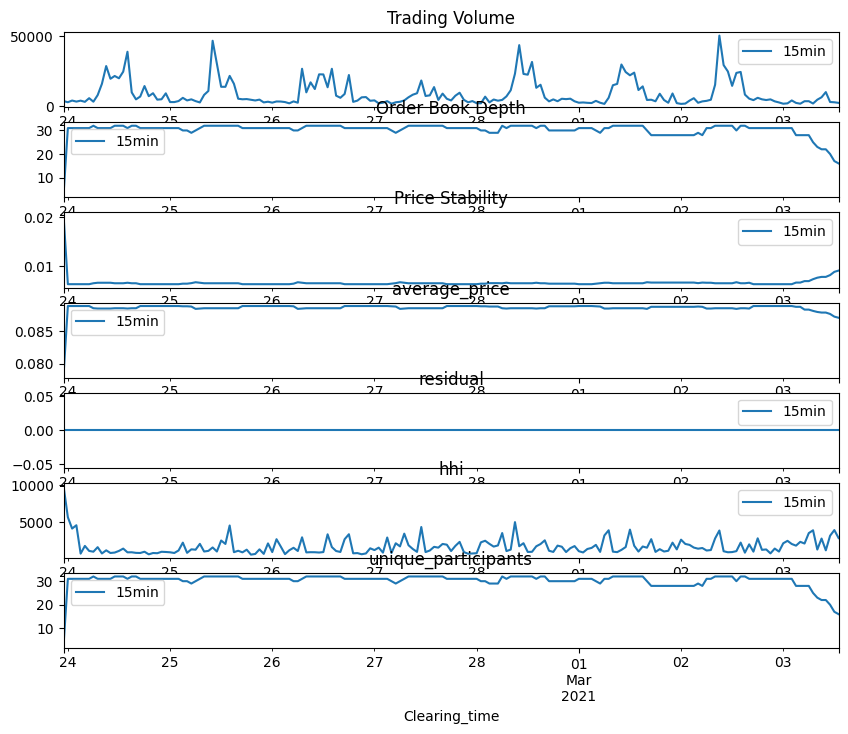

In [17]:
# Plotting the performance comparison
fig, axs = plt.subplots(7, 1, figsize=(10, 8))

for i, freq in enumerate(freqs):
    performance_data['Trading_volume'].plot(ax=axs[0], label=freq)
    performance_data['Order_book_depth'].plot(ax=axs[1], label=freq)
    performance_data['Price_stability'].plot(ax=axs[2], label=freq)
    performance_data['average_price'].plot(ax=axs[3], label=freq)
    performance_data['residual'].plot(ax=axs[4], label=freq)
    performance_data['hhi'].plot(ax=axs[5], label=freq)   
    performance_data['unique_participants'].plot(ax=axs[6], label=freq)   
    
axs[0].set_title('Trading Volume')
axs[1].set_title('Order Book Depth')
axs[2].set_title('Price Stability')
axs[3].set_title('average_price')
axs[4].set_title('residual')
axs[5].set_title('hhi')
axs[6].set_title('unique_participants')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()
axs[5].legend()
axs[6].legend()

plt.tight_layout()
plt.show()


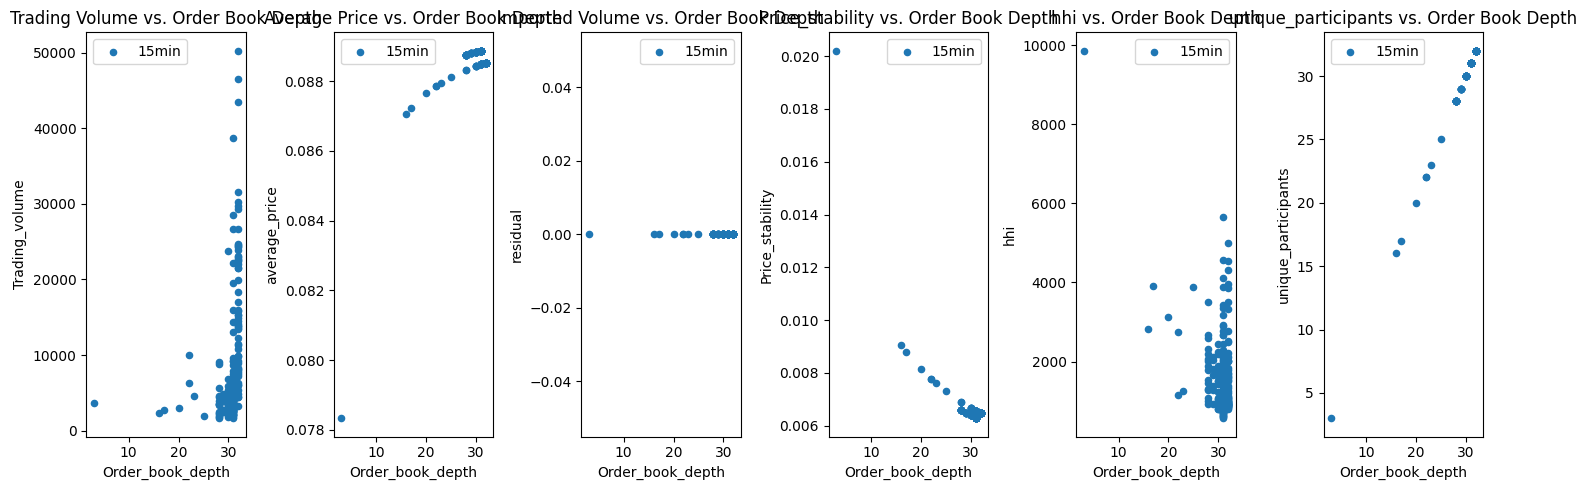

In [18]:
fig, axs = plt.subplots(1, 6, figsize=(15, 5))

for freq in freqs:
    performance_data.plot.scatter(x='Order_book_depth', y='Trading_volume', ax=axs[0], label=freq)
    performance_data.plot.scatter(x='Order_book_depth', y='average_price', ax=axs[1], label=freq)
    performance_data.plot.scatter(x='Order_book_depth', y='residual', ax=axs[2], label=freq)
    performance_data.plot.scatter(x='Order_book_depth', y='Price_stability', ax=axs[3], label=freq)
    performance_data.plot.scatter(x='Order_book_depth', y='hhi', ax=axs[4], label=freq)
    performance_data.plot.scatter(x='Order_book_depth', y='unique_participants', ax=axs[5], label=freq)
    
axs[0].set_title('Trading Volume vs. Order Book Depth')
axs[1].set_title('Average Price vs. Order Book Depth')
axs[2].set_title('Imported Volume vs. Order Book Depth')
axs[3].set_title('Price_stability vs. Order Book Depth')
axs[4].set_title('hhi vs. Order Book Depth')
axs[5].set_title('unique_participants vs. Order Book Depth')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()
axs[5].legend()

plt.tight_layout()
plt.show()


In [19]:
results = sorted_data
results['prosumer_cleared_volume'] = 0
results.loc[results['type'] == 'prosumer', 'prosumer_cleared_volume'] = results.loc[results['type'] == 'prosumer', 'cleared_volume'].fillna(0)

results['large_scale_pv_cleared_volume'] = 0
results.loc[results['type'] == 'large_scale_pv', 'large_scale_pv_cleared_volume'] = results.loc[results['type'] == 'large_scale_pv', 'cleared_volume'].fillna(0)

results['fixed_generated_cleared_volume'] = 0
results.loc[results['type'] == 'fixed_generator', 'fixed_generated_cleared_volume'] = results.loc[results['type'] == 'fixed_generator', 'cleared_volume'].fillna(0)
results

                     user  quantity_bid             type  cost_price  Demand  \
time                                                                           
2021-02-23 23:00:00    32         21250  fixed_generator       0.055    3658   
2021-02-23 23:00:00    23            50         prosumer       0.090    3658   
2021-02-23 23:00:00    19           102         prosumer       0.090    3658   
2021-02-24 00:00:00    32         13840  fixed_generator       0.055    2855   
2021-02-24 00:00:00    18            26         prosumer       0.090    2855   
...                   ...           ...              ...         ...     ...   
2021-03-03 13:00:00    26            48         prosumer       0.090    2388   
2021-03-03 13:00:00    18           624         prosumer       0.090    2388   
2021-03-03 13:00:00    22           140         prosumer       0.090    2388   
2021-03-03 13:00:00     2            38         prosumer       0.090    2388   
2021-03-03 13:00:00     3           120 

/tmp/ipykernel_20/447077089.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  second_df = results.groupby(results.index).sum()


<AxesSubplot: xlabel='time'>

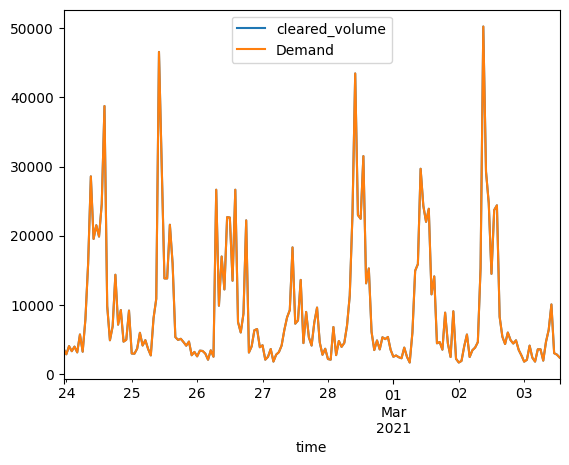

In [20]:
second_df = results.groupby(results.index).sum()
second_df['Demand'] = all_unique_bids.groupby(all_unique_bids.index)['quantity_bid'].sum()
second_df[['cleared_volume','Demand']].plot()

In [21]:
second_df['prosumer_cleared_volume (%)'] = second_df['prosumer_cleared_volume'] / second_df['Demand'] * 100
second_df['prosumer_cost'] = second_df['prosumer_cleared_volume'] * prosumer_cost_price

second_df['large_scale_pv_cleared_volume (%)'] = second_df['large_scale_pv_cleared_volume'] / second_df['Demand'] * 100
second_df['large_scale_pv_cost'] = second_df['large_scale_pv_cleared_volume'] * large_scale_pv_cost_price

second_df['fixed_generated_cleared_volume (%)'] = second_df['fixed_generated_cleared_volume'] / second_df['Demand'] * 100
second_df['fixed_generated_cost'] = second_df['fixed_generated_cleared_volume'] * fixed_generator_cost_price

second_df['total_cost'] = second_df['prosumer_cost'] + second_df['large_scale_pv_cost'] + second_df['fixed_generated_cost']
second_df['final_cost_price'] = second_df['total_cost'] / second_df['Demand']

second_df.fillna(0, inplace=True)

second_df


                     user  quantity_bid  cost_price  Demand  \
time                                                          
2021-02-23 23:00:00    74         21402       0.235    3658   
2021-02-24 00:00:00   497         18452       2.755    2855   
2021-02-24 01:00:00   497         17707       2.755    4037   
2021-02-24 02:00:00   497         20138       2.755    3303   
2021-02-24 03:00:00   497         19190       2.755    3961   
...                   ...           ...         ...     ...   
2021-03-03 09:00:00   348         31308       1.933    6381   
2021-03-03 10:00:00   348         30663       1.933   10061   
2021-03-03 11:00:00   320         29454       1.753    3012   
2021-03-03 12:00:00   282         25656       1.483    2812   
2021-03-03 13:00:00   257         23734       1.393    2388   

                     cumulative_cleared_volume  cleared_volume  \
time                                                             
2021-02-23 23:00:00                      63952  

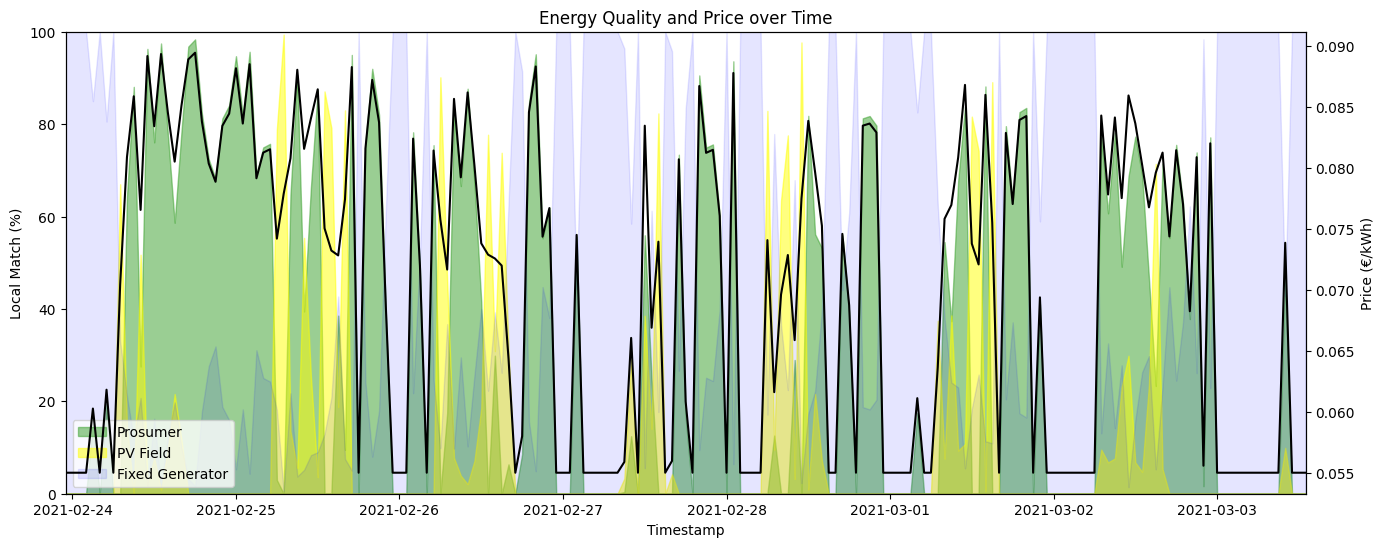

In [22]:
import matplotlib.pyplot as plt

# Group the data by the timestamp column
# create a second y-axis
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()

# plot the data on each y-axis
ax1.fill_between(second_df.index, second_df["prosumer_cleared_volume (%)"], color="#369f28", alpha=0.5, label="Prosumer")
ax1.fill_between(second_df.index, second_df["large_scale_pv_cleared_volume (%)"], color="yellow", alpha=0.5, label="PV Field")
ax1.fill_between(second_df.index, second_df["fixed_generated_cleared_volume (%)"], color="blue", alpha=0.1, label="Fixed Generator")
ax2.plot(second_df.index, second_df["final_cost_price"], color="black", label='Price €/kWh')

# set the limits and labels for each axis
ax1.set_ylim(0, 100)
ax1.set_xlim(second_df.index.min(), second_df.index.max())
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Local Match (%)')
ax2.set_ylabel('Price (€/kWh)')

# combine legends from both axes
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')

# set a single title and remove duplicate legend
plt.title("Energy Quality and Price over Time")
plt.legend().remove()

# display the plot
plt.show()


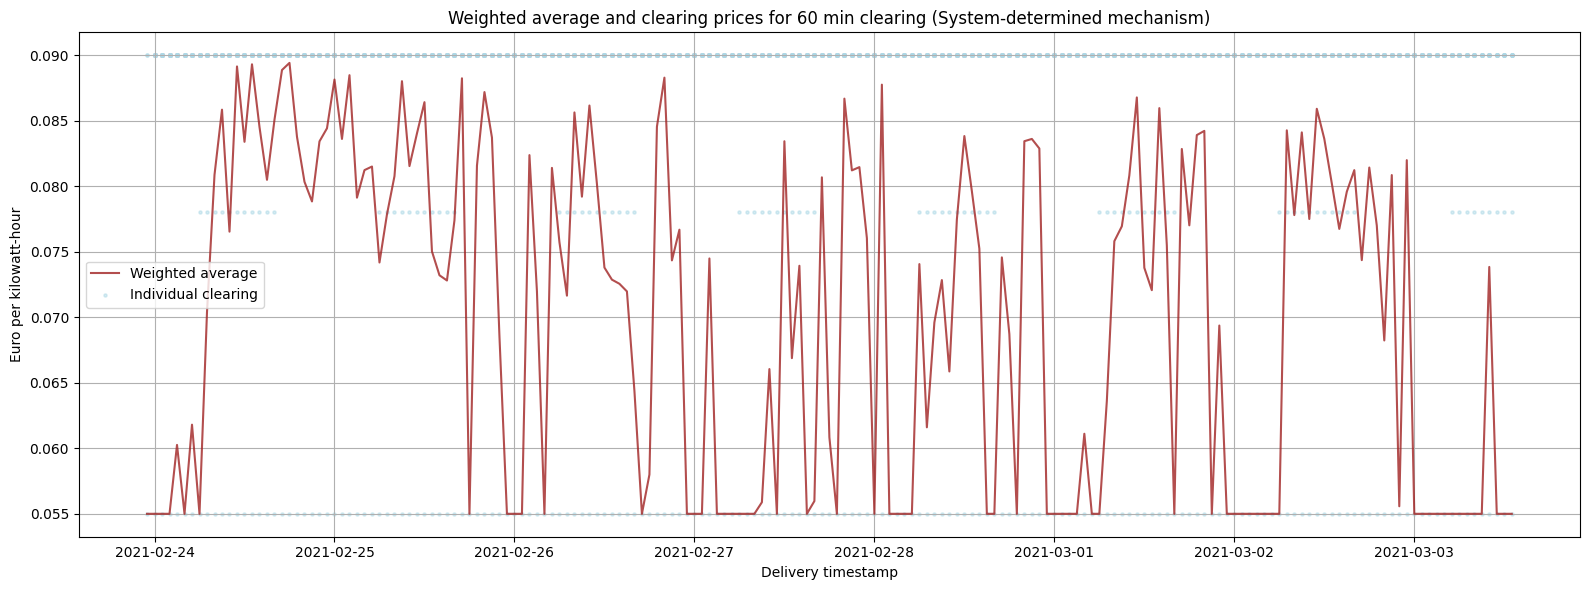

0.012617914166612735
0.07005402269580004


In [23]:
# Increase figure size
plt.figure(figsize=(16, 6))

# Plot weighted average
xvalues = second_df.index
yvalues = second_df['final_cost_price'].tolist()
plt.plot(xvalues, yvalues, color="#a02222", alpha=0.8, label="Weighted average")

# Plot second line
xvalues = results.index
yvalues = results['cost_price'].tolist()
plt.scatter(xvalues, yvalues, color="LightBlue", alpha=0.5, s=5, label="Individual clearing")

# Add labels, title, and legend
plt.xlabel("Delivery timestamp")
plt.ylabel("Euro per kilowatt-hour")
plt.title("Weighted average and clearing prices for 60 min clearing (System-determined mechanism)")
plt.legend()

# Add grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()

# Save the plot as a vector plot in EPS format
plt.savefig("syst_60min.eps", format="eps")

# Show the plot
plt.show()

volatility_syst = second_df['final_cost_price'].std()
print(volatility_syst)
wavg_syst = second_df['final_cost_price'].mean()
print(wavg_syst)

In [24]:
second_df.sort_index()
start_date = "2021-02-23 23:15:00"
end_date = "2021-02-25 00:00:00"
mask = (second_df.index >= start_date) & (second_df.index < end_date)
second_df = second_df.loc[mask]
second_df

                     user  quantity_bid  cost_price  Demand  \
time                                                          
2021-02-24 00:00:00   497         18452       2.755    2855   
2021-02-24 01:00:00   497         17707       2.755    4037   
2021-02-24 02:00:00   497         20138       2.755    3303   
2021-02-24 03:00:00   497         19190       2.755    3961   
2021-02-24 04:00:00   497         19551       2.755    3128   
2021-02-24 05:00:00   497         19858       2.755    5716   
2021-02-24 06:00:00   528         20664       2.833    3230   
2021-02-24 07:00:00   521         29422       2.743    7895   
2021-02-24 08:00:00   521         35942       2.743   15939   
2021-02-24 09:00:00   521         50906       2.743   28577   
2021-02-24 10:00:00   521         58306       2.743   19537   
2021-02-24 11:00:00   528         51032       2.833   21516   
2021-02-24 12:00:00   528         52171       2.833   19875   
2021-02-24 13:00:00   528         60307       2.833   2

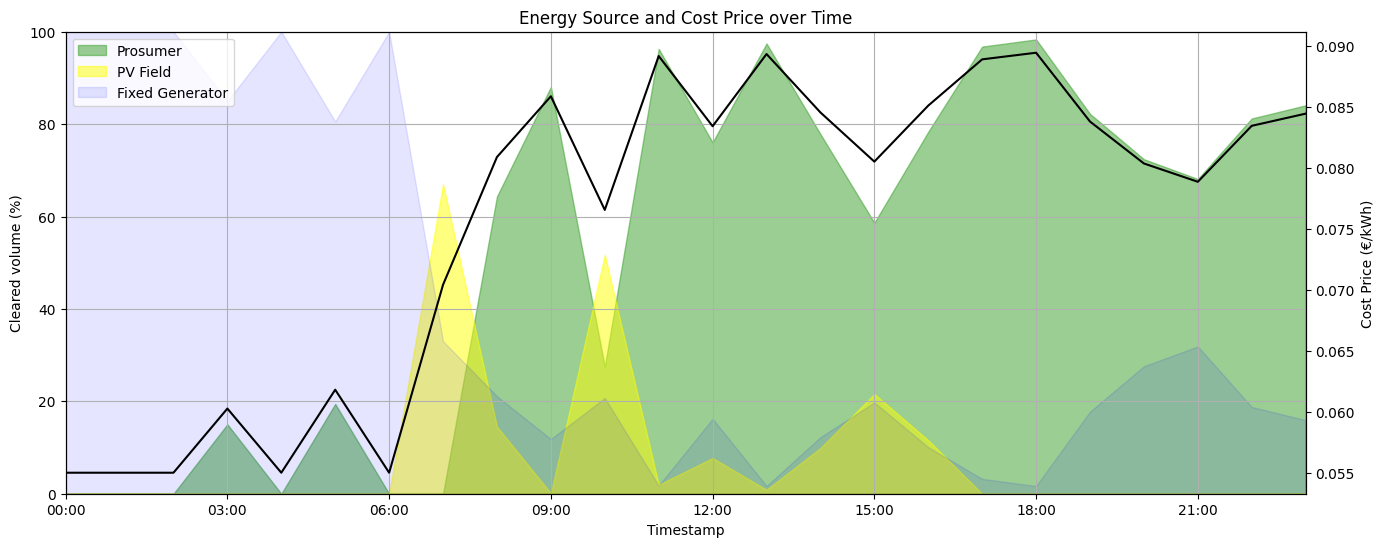

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Group the data by the timestamp column
# create a second y-axis
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()

# plot the data on each y-axis
ax1.fill_between(second_df.index, second_df["prosumer_cleared_volume (%)"], color="#369f28", alpha=0.5, label="Prosumer")
ax1.fill_between(second_df.index, second_df["large_scale_pv_cleared_volume (%)"], color="yellow", alpha=0.5, label="PV Field")
ax1.fill_between(second_df.index, second_df["fixed_generated_cleared_volume (%)"], color="blue", alpha=0.1, label="Fixed Generator")
ax2.plot(second_df.index, second_df["final_cost_price"], color="black", label='Price €/kWh')

# set the limits and labels for each axis
ax1.set_ylim(0, 100)
ax1.set_xlim(second_df.index.min(), second_df.index.max())
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Cleared volume (%)')
ax2.set_ylabel('Cost Price (€/kWh)')

# Format the x-axis tick labels as HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add grid lines
ax1.grid(True)

# combine legends from both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# set a single title and remove duplicate legend
plt.title("Energy Source and Cost Price over Time")
plt.legend().remove()

# Save the plot as a vector plot in EPS format
plt.savefig("energy_plot_15.eps", format="eps")

# Display the plot
plt.show()
